In [1]:
import pandas as pd
import glob

file_name = glob.glob('../article/headline_noun_keyword*')

keyword_df = []
for file in file_name:
    df = pd.read_pickle(file)
    keyword_df.append(df)

keyword_all = pd.concat(keyword_df, ignore_index = True)
all_article = keyword_all[keyword_all['week'] <= 807]
all_article

,date,co,headline,week,pos
0,2006.01.01. 오후 11:23,매일경제,취득세ㆍ등록세 0.5%P씩 인하,0,"[취득세, 인하]"
1,2006.01.01. 오후 11:23,매일경제,양도세 부담 덜자 하반기 매물 늘듯,0,"[양도세, 부담, 하반기, 매물]"
2,2006.01.01. 오후 11:23,매일경제,서울 대치동 57평형 보유세 651만원,0,"[서울, 대치동, 평, 보유, 세, 만, 원]"
3,2006.01.01. 오후 11:23,매일경제,양도세 줄이는 방법 필요경비 증빙서류 꼭 챙기자,0,"[양도세, 방법, 필요, 경비, 증빙, 서류]"
4,2006.01.01. 오후 11:23,매일경제,올해 실거래가 신고제 폭풍 이중계약서 관행 사라진다,0,"[올해, 실, 거래, 신고, 폭풍, 이중, 계약서, 관행]"
...,...,...,...,...,...
1065646,2021.06.26. 오전 5:00,뉴시스,비상 걸린 전세⑥전문가들 꼬일 대로 꼬였다…규제라도 풀어야,807,"[비상, 전세, 전문가, 대로, 규제]"
1065647,2021.06.26. 오전 3:04,세계일보,‘래미안 원베일리’ 청약에 만점 통장 등장… 올해 두 번째,807,"[래미안, 원, 베일리, 청약, 만점, 통장, 등장, 올해, 번]"
1065648,2021.06.26. 오전 3:01,동아일보,‘10억 로또 청약’ 원베일리… 7인 가족 만점통장 나왔다,807,"[억, 로또, 청약, 원, 베일리, 인, 가족, 만점, 통장]"
1065649,2021.06.26. 오전 3:01,동아일보,故 이건희 회장 이태원 주택 210억에 매물로,807,"[이건희, 회장, 이태원, 주택, 억, 매물]"


In [2]:
from datetime import date
start_date = date(2006,1,1)
mh = date(2008,2,24)
mb = date(2013,2,24)
gh = date(2016,12,9)
ga = date(2017,5,10) #황교안 대행
ji = date(2022,5,9)
mhw = (mh - start_date).days//7
mbw = (mb - start_date).days//7
ghw = (gh - start_date).days//7
gaw = (ga - start_date).days//7
jiw = (ji - start_date).days//7

In [3]:
gov = ['mh','mb','gh','ji']

In [4]:
time_range = {}
time_range['mh'] = (0,mhw)
time_range['mb'] = (mhw,mbw)
time_range['gh'] = (mbw,ghw)
#time_range['ga'] = (ghw,gaw)
time_range['ji'] = (gaw,808)

In [5]:
gov_article = {}
for g in gov:
    week_s, week_e = time_range[g]
    gov_article[g] = all_article[(all_article['week'] >= week_s) & (all_article['week'] < week_e)]

In [6]:
gov_tokenized_data = {}
for g in gov:
    tokenized_data = []
    for keyword in gov_article[g]['pos']:
        tokenized_data.append(keyword)
    gov_tokenized_data[g] = tokenized_data

In [8]:
from gensim.models import Word2Vec
model = {}

for g in gov:
    m = Word2Vec(sentences = gov_tokenized_data[g], window = 5, min_count = 100, workers = 4, sg = 1)
    model[g] = m

In [9]:
for g in gov:
    print(model[g].wv.vectors.shape)

(816, 100)
(2213, 100)
(2732, 100)
(3367, 100)


In [10]:
gov_similar_up_origin = {}
for g in gov:
    similar_up_origin = [i[0] for i in model[g].wv.most_similar("상승")]
    similar_up_origin.append('상승')
    gov_similar_up_origin[g] = similar_up_origin

In [11]:
gov_similar_up_expend = {}
for g in gov:
    similar_up_expend = [(suo,model[g].wv.similarity('상승',suo)) for suo in gov_similar_up_origin[g]]
    for suo in gov_similar_up_origin[g]:
        similar_suo = [i[0] for i in model[g].wv.most_similar(suo)]
        for ssuo in similar_suo:
            similar_up_expend.append((ssuo,model[g].wv.similarity('상승',ssuo)))
    gov_similar_up_expend[g] = similar_up_expend

In [12]:
gov_similar_up_df = {}
for g in gov:
    gov_similar_up_expend[g] = list(set(gov_similar_up_expend[g]))
    similar_up_df = pd.DataFrame(gov_similar_up_expend[g])
    similar_up_df = similar_up_df.sort_values(by = 1, ascending = False,ignore_index = True)
    similar_up_df.columns = ['keyword','similarity_with_상승']
    gov_similar_up_df[g] = similar_up_df

In [13]:
gov_similar_down_origin = {}
for g in gov:
    similar_down_origin = [i[0] for i in model[g].wv.most_similar("하락")]
    similar_down_origin.append('하락')
    gov_similar_down_origin[g] = similar_down_origin

In [14]:
gov_similar_down_expend = {}
for g in gov:
    similar_down_expend = [(suo,model[g].wv.similarity('하락',suo)) for suo in gov_similar_down_origin[g]]
    for suo in gov_similar_down_origin[g]:
        similar_suo = [i[0] for i in model[g].wv.most_similar(suo)]
        for ssuo in similar_suo:
            similar_down_expend.append((ssuo,model[g].wv.similarity('하락',ssuo)))
    gov_similar_down_expend[g] = similar_down_expend

In [15]:
gov_similar_down_df = {}
for g in gov:
    gov_similar_down_expend[g] = list(set(gov_similar_down_expend[g]))
    similar_down_df = pd.DataFrame(gov_similar_down_expend[g])
    similar_down_df = similar_down_df.sort_values(by = 1, ascending = False,ignore_index = True)
    similar_down_df.columns = ['keyword','similarity_with_하락']
    gov_similar_down_df[g] = similar_down_df

1. 중복된 키워드 지우기

In [16]:
gov_up_word = {}
for g in gov:
    up_word = []
    _list = [i for i in gov_similar_up_df[g]['keyword']]
    for i in gov_similar_up_df[g]['keyword']:
        if i not in _list:
            up_word.append(i)
        if len(up_word) == 5:
            break
    gov_up_word[g] = up_word

In [17]:
gov_down_word = {}
for g in gov:
    down_word = []
    _list = [i for i in gov_similar_down_df[g]['keyword']]
    for i in gov_similar_down_df[g]['keyword']:
        if i not in _list:
            down_word.append(i)
        if len(down_word) == 5:
            break
    gov_down_word[g] = down_word

2. 중복된 키워드가 up에 가까운지 down에 가까운지 확인하고 가까운 쪽으로

In [18]:
gov_up_word = {}
for g in gov:
    up_word = []
    _list = [i for i in gov_similar_down_df[g]['keyword']]
    for i in gov_similar_up_df[g]['keyword']:
        if i not in _list:
            up_word.append(i)
        else:
            if float(gov_similar_up_df[g][gov_similar_up_df[g]['keyword'] == i]['similarity_with_상승']) >= float(gov_similar_down_df[g][gov_similar_down_df[g]['keyword'] == i]['similarity_with_하락']):
                up_word.append(i)
        if len(up_word) == 5:
            break
    gov_up_word[g] = up_word

In [19]:
gov_down_word = {}
for g in gov:
    down_word = []
    _list = [i for i in gov_similar_up_df[g]['keyword']]
    for i in gov_similar_down_df[g]['keyword']:
        if i not in _list:
            down_word.append(i)
        else:
            if float(gov_similar_down_df[g][gov_similar_down_df[g]['keyword'] == i]['similarity_with_하락']) >= float(gov_similar_up_df[g][gov_similar_up_df[g]['keyword'] == i]['similarity_with_상승']):
                down_word.append(i)
        if len(down_word) == 5:
            break
    gov_down_word[g] = down_word

In [23]:
gov_up_word

{'mh': ['상승', '급등', '수준', '전셋값', '과천'],
 'mb': ['상승', '상승세', '급등', '안정세', '강세'],
 'gh': ['상승', '상승세', '오름폭', '오름세', '급등'],
 'ji': ['상승', '상승세', '오름세', '오름폭', '급등']}

In [24]:
gov_down_word

{'mh': ['하락', '하락세', '오름세', '상승세', '둔화'],
 'mb': ['하락', '하락세', '낙폭', '급락', '오름세'],
 'gh': ['하락', '하락세', '보합', '둔화', '보합세'],
 'ji': ['하락', '하락세', '약세', '보합', '둔화']}

C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


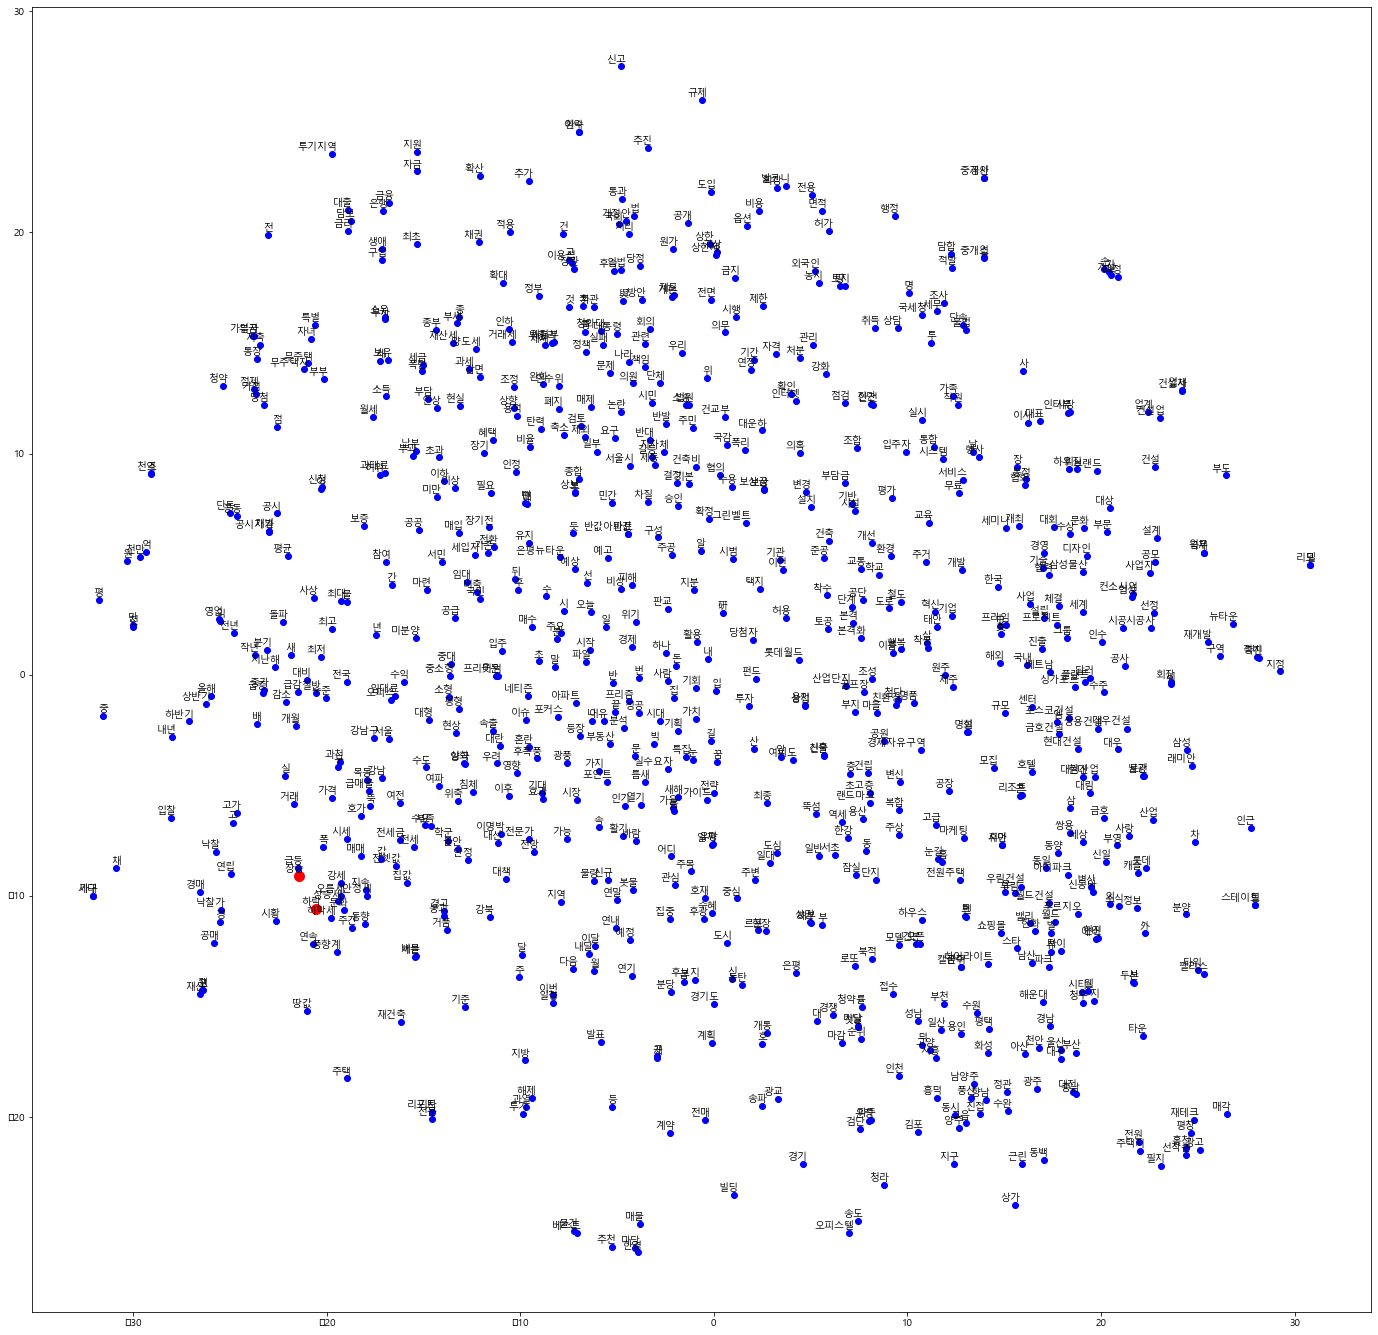

C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


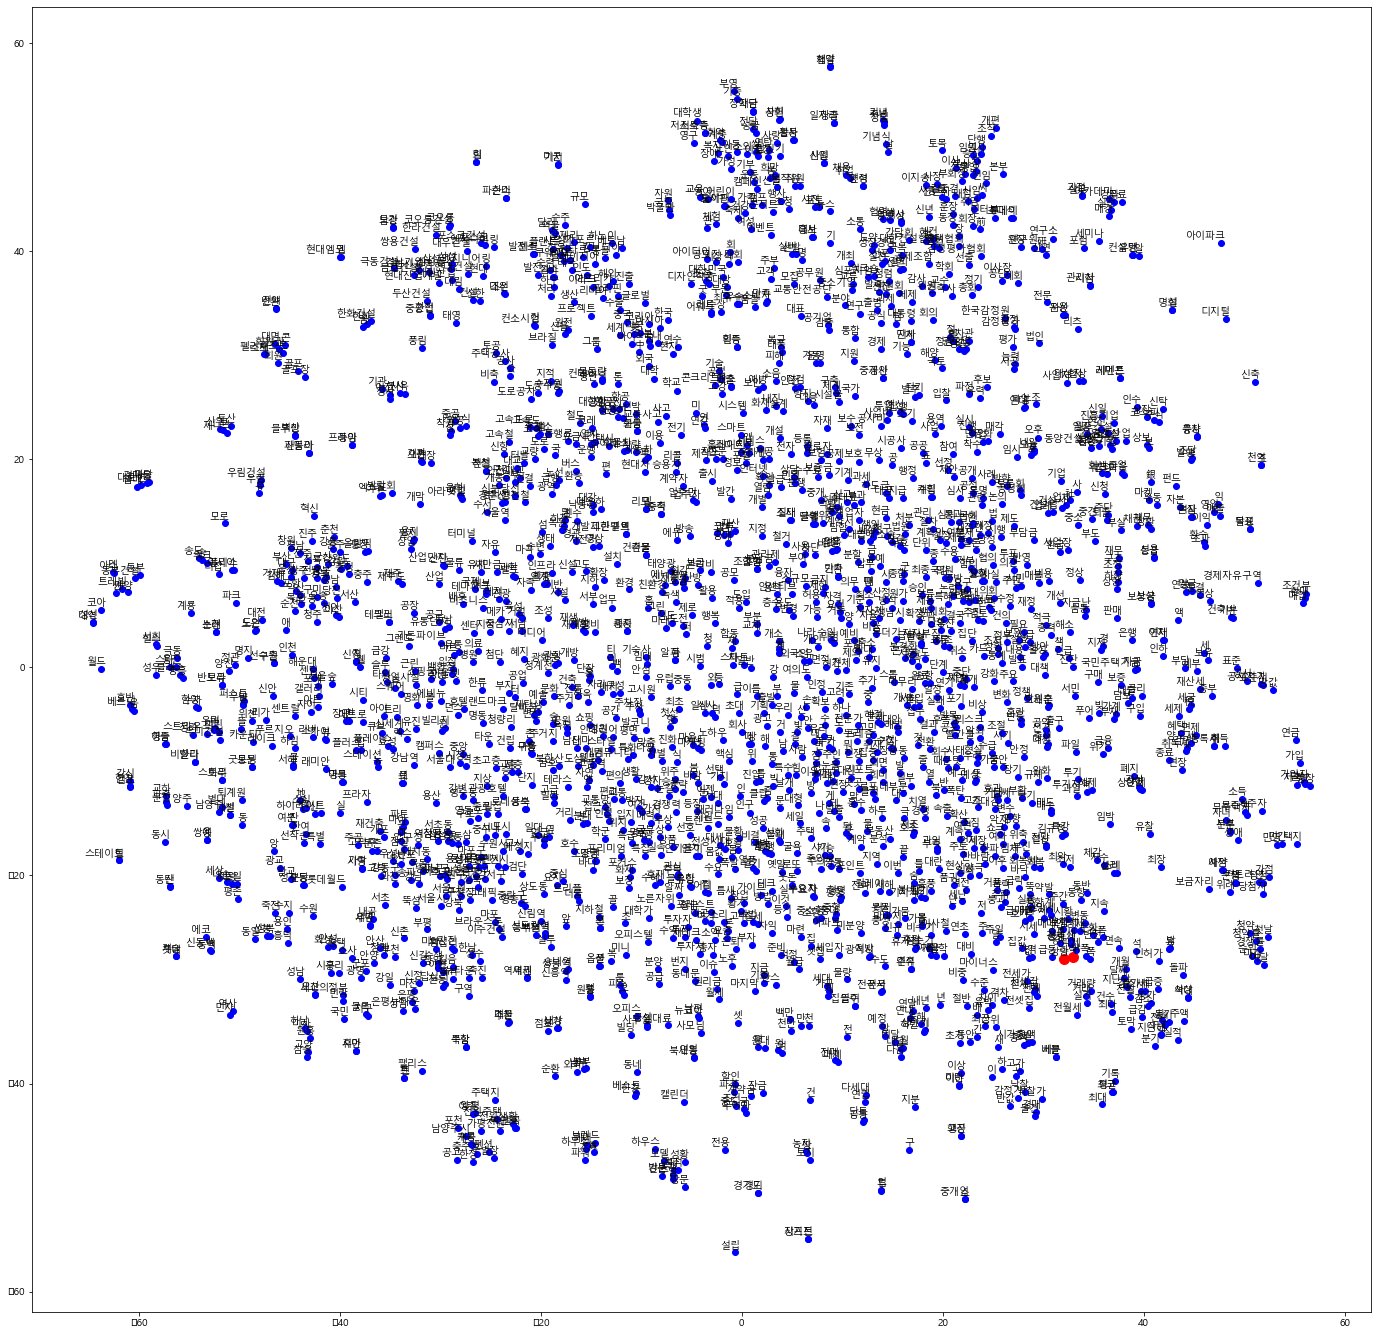

C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


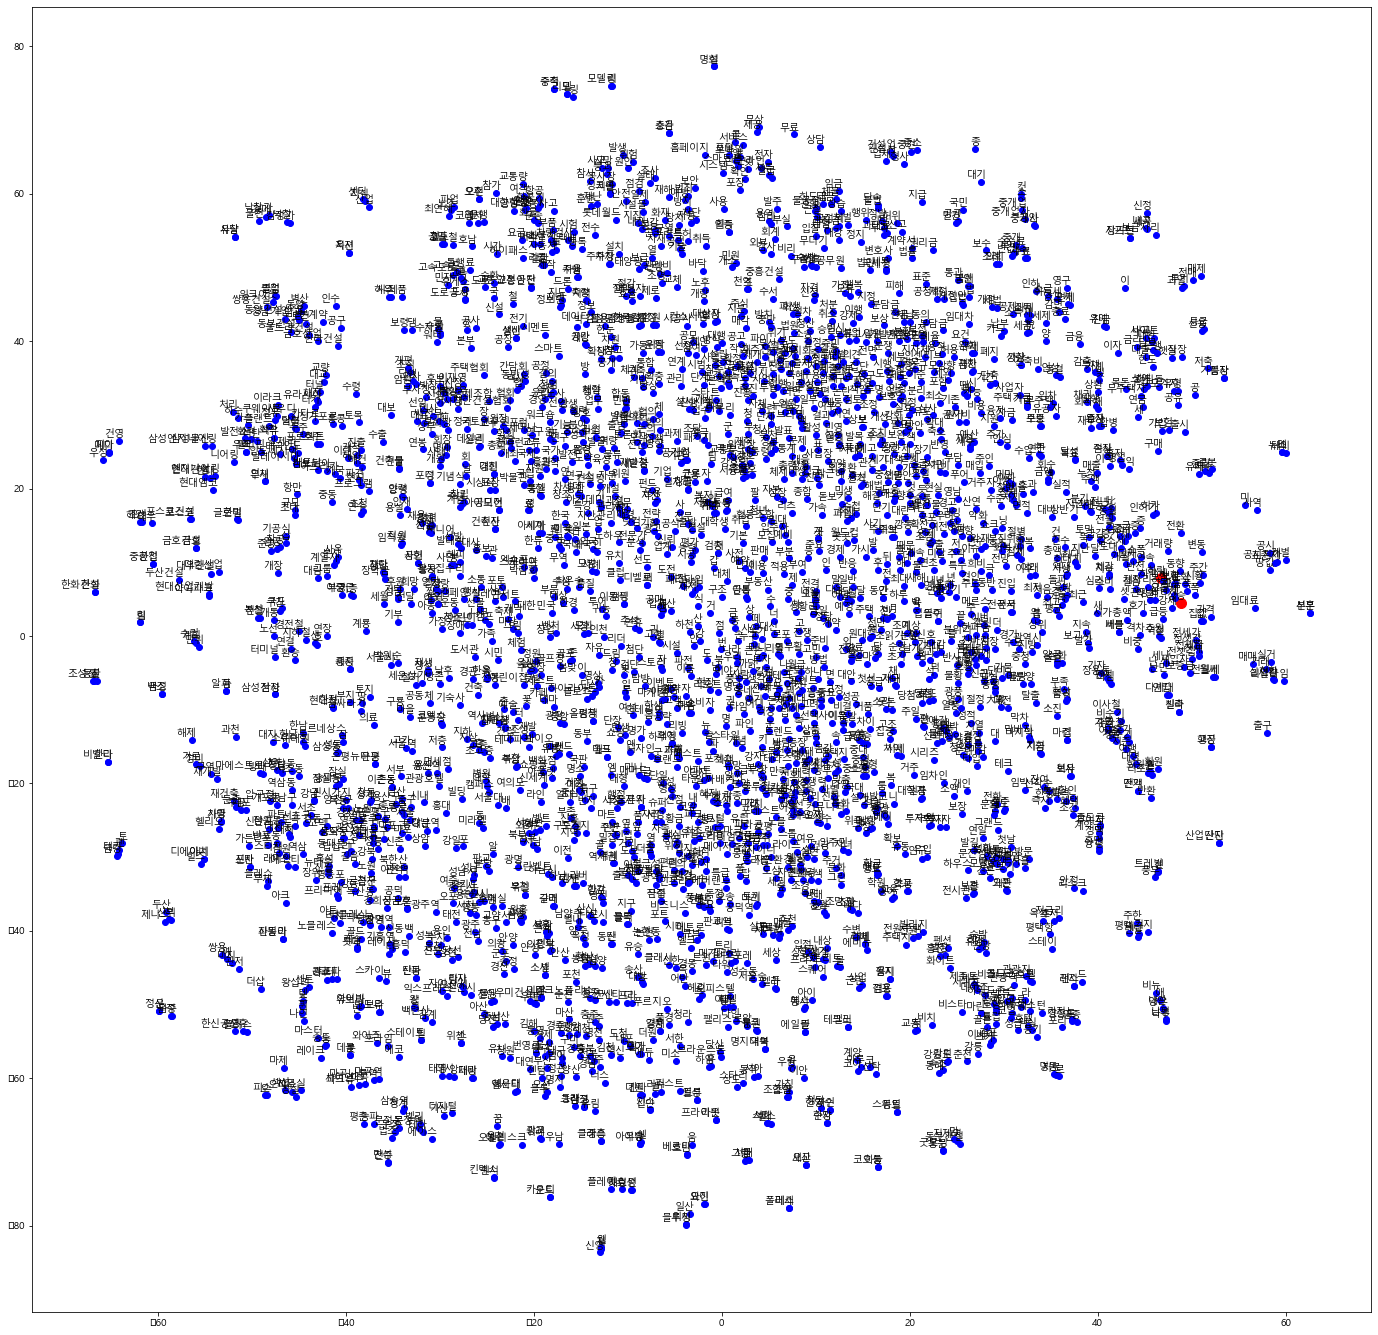

C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dudrb\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


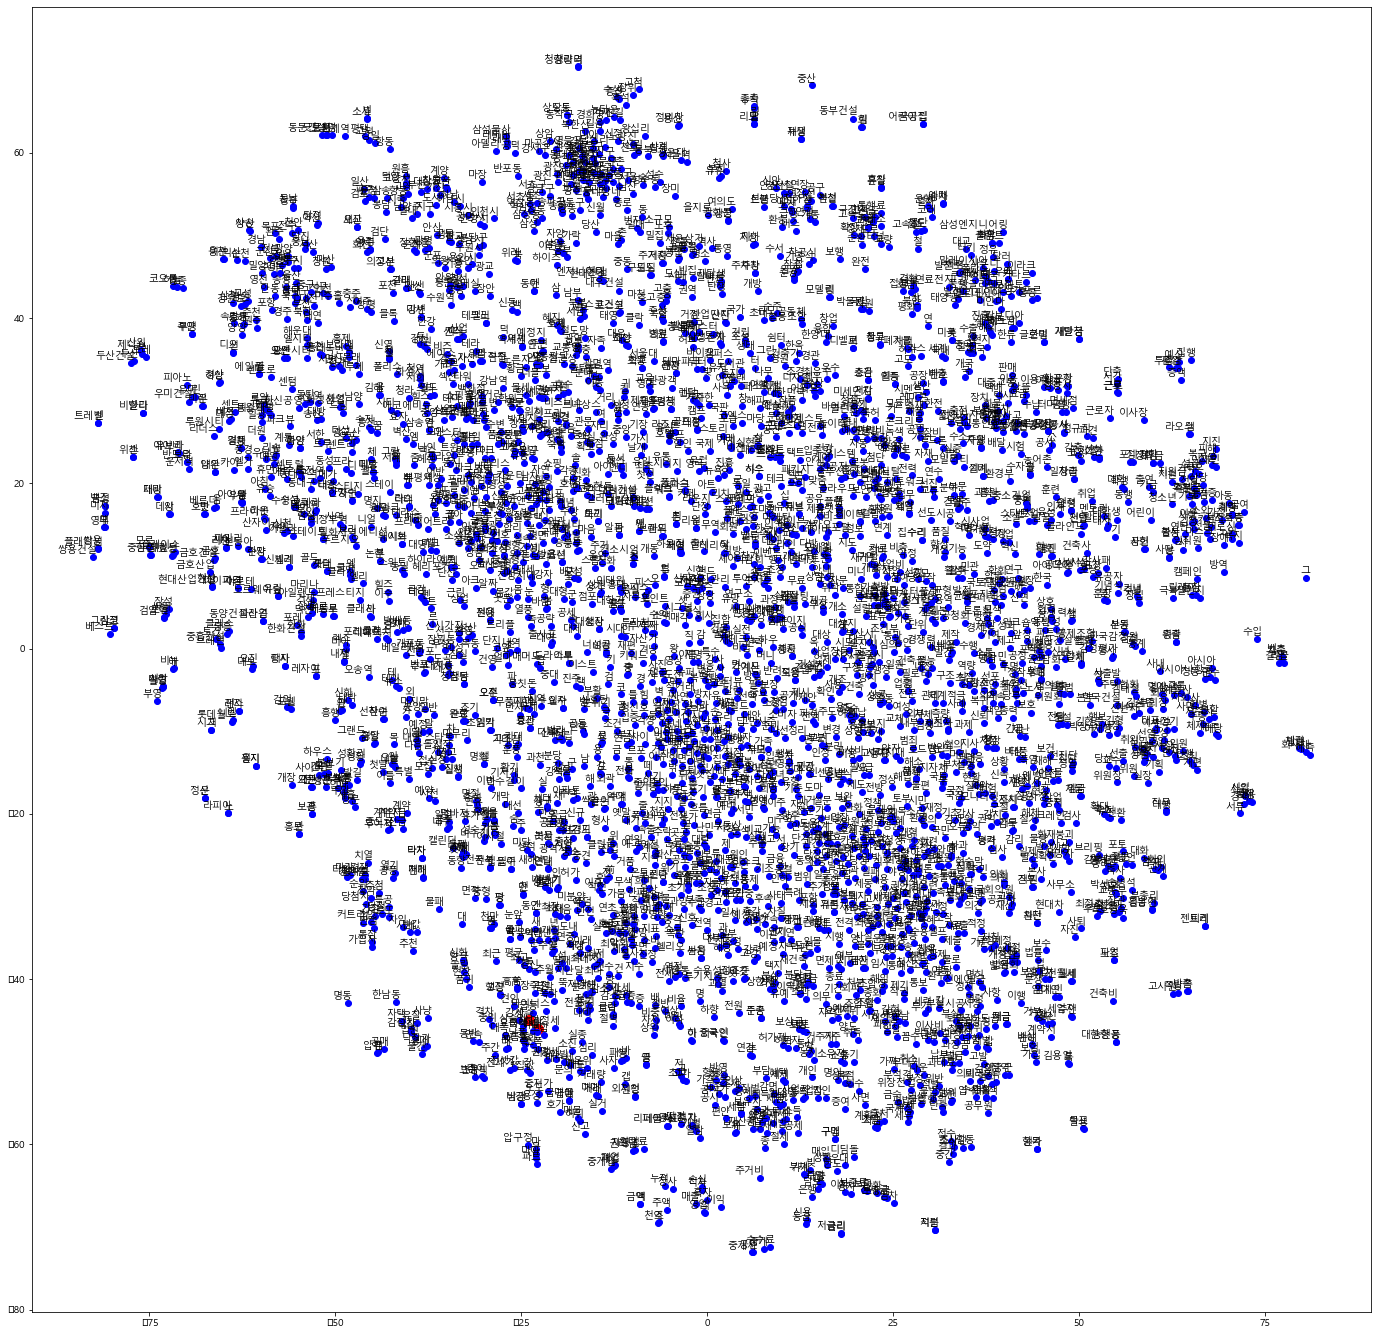

In [20]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)


"Creates and TSNE model and plots it"

gov_x = {}
gov_y = {}
gov_words = {}
for g in gov:
    labels = []
    tokens = []
    words = list(model[g].wv.index_to_key)
    for word in words:
        tokens.append(model[g].wv[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(24, 24)) 
    for i in range(len(x)):
        if (labels[i] == '상승') or (labels[i] == '하락'):
            plt.scatter(x[i],y[i], s = 100, color = 'r')
        else:
            plt.scatter(x[i],y[i], color = 'b')
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom', )
    plt.savefig(f'../article/keyword_vector_{g}.png', dpi=300)
    plt.show()
    gov_x[g] = x
    gov_y[g] = y
    gov_words[g] = words

In [21]:
uw_index = []
dw_index = []

for uw in up_word:
    uw_index.append(words.index(uw))
    
for dw in down_word:
    dw_index.append(words.index(dw))
    
uw_vector = []
dw_vector = []

In [22]:
for g in gov:
    ui = words[g].index('상승')
    di = words[g].index('하락')

    print(f'{g} 상승 vector: ({x[g][ui]}, {y[g][ui]})')
    print(f'{g} 하락 vector: ({x[g][di]}, {y[g][di]})')

TypeError: list indices must be integers or slices, not str